# Implementing an Artificial Neural Network From Scratch

Descriptions of artificial neural networks usually include terms like 'deep learning', 'hidden layer', and 'mimicking the neural connectivity of the mammalian brain'.   Terms like these can make neural networks seem mysterious and slightly intimidating to the uninitiated.  In an attempt to both demystify and teach myself artificial neural networks I decided to build one from scratch.  Many open source libraries like tensorflow exist for building large scale, efficient neural networks, and the model presented here is certainly not going to compete with them for high performance machine learning.  Rather, this program allowed me to deconstruct an artificial neural network to it's bare bones components and learn how they work.  So lets get to it.....  

(Side note - you can find all of this code on my github:  https://github.com/jtdean123)

## Neural Network Background

Artificial neural networks (ANN) are supervised machine learning algorithms that can be used for both regression and classification, and here we will focus on classification.  Classifiers learn to predict an output based on an input, and what differentiates an ANN from other machine learning classification algorithms is the structure of the model.  An ANN consists of 'artificial neurons', or nodes, that are loosely connected.  The nodes, in the context of machine learning, can be grouped as input, hidden, or output.  Nodes, just like neurons, produce an output based on an input.  

Consider, for example, the three layer ANN shown below.

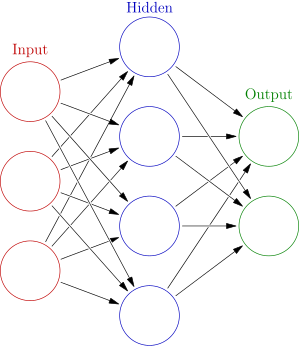

In [2]:
from IPython.display import Image
Image("ANN.png")

Lets start on the left and move to the right.  The input nodes produce a constant output - the input to the model.  The number of input nodes is determined by the dimensionality of the feature data.  For example, if we are trying to predict whether a person is male or female based on their height, weight, and shoe size, the ANN would have three input nodes.  

Each input node feeds feature data into the hidden layer nodes, and this hidden layer is what differentiates an ANN from a classic logistic regression model.  In order to learn a model we need parameters that can be changed, and to incorporate this into the model we say that the input to hidden layer node 1, for example, is given by a linear combination of the input nodes output multiplied by a constant plus a bias term:  

<br>

\begin{equation*}
input_1 =\sum_{k=1}^3 w_k * x_k + b_1
\end{equation*}

<br>

Breaking this down, this means that each node (for the example above) will receive three inputs, one from each input node.  The input from each node is multiplied by a constant, w, and a bias b is added to the sum of the inputs multiplied by the weights.  It is straightforward to generalize this to any number of input and hidden layer nodes.  We next turn to the hidden layer.  The hidden layer nodes, like a neuron, recieve an input and produce an output and as a model builder we have control over how this flow of data happens.  Typically this transformation is done with one of the three functions below, and we call this the activation function.  

** tanH activation:**  

\begin{equation*}
f(x)=\tanh(x)={\frac {2}{1+e^{-2x}}}-1
\end{equation*}

<br>

** sigmoid activation:**  

\begin{equation*}
f(x) = {\frac {1}{1+e^{-x}}}
\end{equation*}

<br>

** rectified linear unit (ReLu)**  

\begin{equation*}
f(x)=\left\{{\begin{array}{rcl}0&{\mbox{for}}&x<0\\x&{\mbox{for}}&x\geq 0\end{array}}\right.
\end{equation*}

<br>

These three activation functions have unique mathematical properties that make them useful for converting inputs to outputs, and in this example I will use the ReLu activation function for the hidden layer because it is both easy to implement and has been shown to work well.  

So far we have seen a set of input nodes feed their information into a hidden layer and the application of an activation function to the input in the hidden layer. Next, the output from the hidden layer is fed to the output nodes in the same manner as the input nodes pass information to the hidden layer, by a linear combination of outputs constructed with weights and bias parameters.  The number of nodes in the output layer is typically the number of classes (or the number of classes -1) that we are trying to predict.  In the example above, we have an output node for each sex, male or female.  We want each node to output a probability that each observation belongs to a given class.  For example, if the person in the first observation is a female and that is our first class, by definition, we would like the output of node 1 to compute a probability of > 0.5 that this observation belongs to class 1.  To convert the inputs from the hidden layers to probabilities we will use the Softmax activation function:    

<br>

\begin{equation*}
p(x_i)={\frac {e^{x_{i}}}{\sum _{k=1}^{K}e^{x_{k}}}}
\end{equation*}

<br>

The process above, input to hidden layer to output, is called forward propagation.  

To calculate the error, or loss, of the model we can use the cross entropy.  For j observations, the total loss of the model is given by:  

<br>

\begin{equation*}
L = -\sum_{i=1}^jy_i*log(p_i)
\end{equation*} 

<br>

In the loss equation above, yi represents the true probability that observation i belongs to class y and p_i is the predicted probability.  Since the true probability is either zero or one, this term is basically the sum of the log predicted probabilities that an observation is classified correctly, and a perfect prediction results in a loss of zero (1 * log(1) = 0).   

Now, we have a model, parameters, and a loss function.  This, similar to other machine learning applications, has turned into an optimization problem.  The optimization of this network is less trivial than, say, simple linear regression because we have multiple layers to contend with.  Solving for the parameters, or w and b for both the input and hidden layers, that minimize the loss is done through back propagation.  In back propagation the errors are propagated backwards and the error associated with each node is determined.  These error values are then used to minimize the loss via gradient descent.  Back propagation is a tricky calculation, and I will refer you to the following great reference to learn more:  http://neuralnetworksanddeeplearning.com/chap2.html  

We now know enough to build a simple ANN from scratch.

In [258]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import random
random.seed(12345)
import pandas as pd

To generate random data to classify we will use make_classification from the sklearn datasets module.  We will generate 1000 observations that belong to one of three classes and are described by two features.

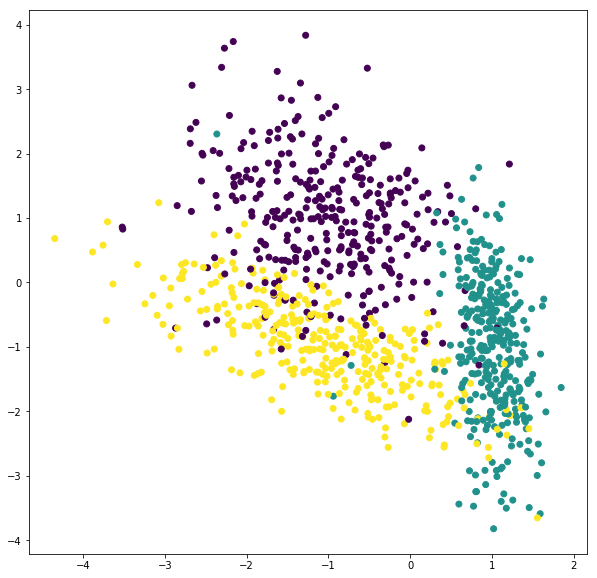

In [34]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=3)
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
plt.show()

As shown above, we have 1000 observations and each belongs to one of three classes.  The first step in building our model is to define a Network class that will contain the parameters and architecture of our ANN.

In [35]:
class Network(object):

    def __init__(self, inputs, hidden, out):
        self.inputs = inputs
        self.hidden = hidden
        self.out = out
        self.W1 = np.random.rand(inputs, hidden)
        self.W2 = np.random.rand(hidden, out)
        self.B1 = np.random.rand(1, hidden)
        self.B2 = np.random.rand(1, out)

The Network instance contains the number of input, hidden, and output nodes.  Additionally, we create the weight matrices W1 and W2 and the biases, B1 and B2.  Remember from above these map one layer to a specific node in the next by building a linear combination of the input nodes.  We will next build the pieces we need for forward propagation, starting with a function that will perform the hidden layer activation.

In [ ]:
def activation(z):
        z = np.maximum(0,z)
        return z

As described above, our hidden layer activation function is the ReLu function.  This function returns zero if an input element is less than zero or the value if greater than zero.  The second activation function we need is for the output, converting unnormalized values to probabilities via the Softmax function.

In [36]:
def softmax(score_output):
        scoresExp = np.exp(score_output)
        scoresNorm = scoresExp / np.sum(scoresExp, axis=1, keepdims=True)
        return scoresNorm

Finally, we can calculate the loss of the model at the output stage using the cross entropy.

In [37]:
def loss(probs, labels):
        totalLoss = 0
        for i, j in zip(probs, labels):
            totalLoss += -np.log(i[j])
        return totalLoss

And there you have it!  The code above allows us to forward propagate a set of input data and generate probabilities that each observation belongs to a specific class, however at this stage the predictions are useless because the weights and biases are generated randomly.  We need to learn the model, and to do this we use back propagation.  Gradient descent in the context of machine learning involves calculating a derivative a loss term and moving in the opposite direction.  After some algebraic gymnastics is can be shown that the gradient for observation i (k = class) is equal to:  

<br>

\begin{equation*}
\frac{\partial L_i}{\partial f_k} = p_k - 1 * (y_i = k)
\end{equation*}

<br>

What this means is that we subtract one from the predicted probability corresponding to the correct class.  Intuitively this makes sense, as it ensures that the gradient is always negative in the direction of the correct class.  We can create a function to calculate this gradient as follows.

In [38]:
def scoreGradient(probs, y):
        for i in range(0, len(probs)):
            probs[i, y[i]] -= 1
        probs = probs / len(probs)
        return probs

We can now put this all together with the following function that will forward and back propagate and update the parameters accordingly.  Note that this updating will be performed 100 times in this example.  

In [39]:
    def model(self, inputs, labels, rate):

        for i in range(0,100):

            # compute output from input layer
            Z1 = np.dot(inputs, self.W1) + self.B1
            # pass through activation function (ReLU) of the hidden layer
            A1 = activation(Z1)

            # compute output from hidden layer
            self.Z2 = np.dot(A1, self.W2) + self.B2
            # perform softmax activation of output layer
            A2 = softmax(self.Z2)

            # determine the loss and output to the terminal
            losses = loss(A2, labels)
            print("i:  ", i, "loss:  ", losses)

            #---- back propogation ----
            # determine gradient for descent
            deltaLoss = scoreGradient(A2, labels)

            # back propogate from output
            deltaW2 = np.dot(A1.T, deltaLoss)
            deltaB2 = np.sum(deltaLoss, axis=0, keepdims=True)

            # back propogate to hidden layer
            delta2 = np.dot(deltaLoss, self.W2.T)
            delta2[A1 <= 0] = 0

            # back propogate to input layer
            deltaW1 = np.dot(inputs.T, delta2)
            deltaB1 = np.sum(delta2, axis=0)

            # adjust the parameters based on gradient descent
            self.W1 -= rate*deltaW1
            self.B1 -= rate*deltaB1

            self.W2 -= rate*deltaW2
            self.B2 -= rate*deltaB2

We can now put this all together as follows below.  Note that we also included two helper functions, predict and boundary, that we will use later.  The predict function returns a class prediction based on the highest probability in an output node and the boundary function will be used to generate predictions from a mesh to visualize classification boundaries. 

In [239]:
class Network(object):

    def __init__(self, inputs, hidden, out):
        self.inputs = inputs
        self.hidden = hidden
        self.out = out
        # initialize parameters to random numbers
        self.W1 = np.random.rand(inputs, hidden)
        self.W2 = np.random.rand(hidden, out)
        self.B1 = np.random.rand(1, hidden)
        self.B2 = np.random.rand(1, out)

    def model(self, inputs, labels, rate):
        
        losses = []
        
        for i in range(0,100):

            # compute output from input layer
            Z1 = np.dot(inputs, self.W1) + self.B1
            # pass through activation function (ReLU) of the hidden layer
            A1 = activation(Z1)

            # compute output from hidden layer
            self.Z2 = np.dot(A1, self.W2) + self.B2
            # perform softmax activation of output layer
            A2 = softmax(self.Z2)

            # determine the loss and output to the terminal
            loss_i = loss(A2, labels)
            losses.append(loss_i)

            #---- back propogation ----
            # determine gradient for descent
            deltaLoss = scoreGradient(A2, labels)

            # back propogate from output
            deltaW2 = np.dot(A1.T, deltaLoss)
            deltaB2 = np.sum(deltaLoss, axis=0, keepdims=True)

            # back propogate to hidden layer
            delta2 = np.dot(deltaLoss, self.W2.T)
            delta2[A1 <= 0] = 0

            # back propogate to input layer
            deltaW1 = np.dot(inputs.T, delta2)
            deltaB1 = np.sum(delta2, axis=0)

            # adjust the parameters based on gradient descent
            self.W1 -= rate*deltaW1
            self.B1 -= rate*deltaB1

            self.W2 -= rate*deltaW2
            self.B2 -= rate*deltaB2
        
        return losses
    
    def predict(self, labels):
        predictions = softmax(self.Z2)
        
        output = []
        for i in range(len(predictions)):
            if predictions[i].argmax() == labels[i]:
                output.append(1)
            else:
                output.append(0)
        
        return output
    
    def boundary(self, meshX):
        Z1 = np.dot(meshX, self.W1) + self.B1
        # pass through activation function (ReLU) of the hidden layer
        A1 = activation(Z1)
        
        Z2 = np.dot(A1, self.W2) + self.B2
        # perform softmax activation of output layer
        A2 = softmax(Z2)

        return np.argmax(A2, axis=1)
        

def softmax(score_output):
        scoresExp = np.exp(score_output)
        scoresNorm = scoresExp / np.sum(scoresExp, axis=1, keepdims=True)
        return scoresNorm

def activation(z):
        z = np.maximum(0,z)
        return z

def loss(probs, labels):
        totalLoss = 0
        for i, j in zip(probs, labels):
            totalLoss += -np.log(i[j])
        return totalLoss

def scoreGradient(probs, y):
        for i in range(0, len(probs)):
            probs[i, y[i]] -= 1
        probs = probs / len(probs)
        return probs

Not too bad!  The hyperparamters for an ANN are the number of layers of hidden nodes, the number of hidden nodes in each layer, and the learning rate.  The learning rate adjust the rate of descent in the minimization of the loss.  We will keep it simple for this example and only consider a three layer model with two inputs, three outputs, and a to be determined number of hidden layer nodes.  We can start by determining how quickly the loss decreases using different numbers of hidden layer nodes and a learning rate of 0.5.

In [240]:
errors = pd.DataFrame()

hidden_nodes = [2, 5, 10, 20, 100]
for i in hidden_nodes:
    ann = Network(2, i, 3)
    errors_ann = ann.model(X, y, .5)
    errors[str(i)] = errors_ann

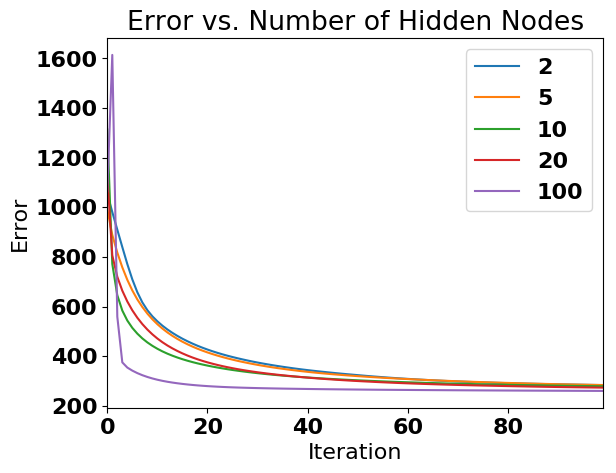

In [241]:
font = {'weight' : 'bold',
        'size'   : 16}
    
plt.rc('font', **font)

errors.plot()

plt.ylabel('Error')
plt.xlabel('Iteration')
plt.title('Error vs. Number of Hidden Nodes')

plt.figure(figsize=(10, 10))

plt.show()
plt.rcdefaults()

As shown above, we find that the decrease in error is proportional to the number of of nodes in the hidden layer, meaning that more hidden nodes results in convergence to the minimum error fastest (< 10 cycles).  Note that the error does not decrease to zero, and this is because the model is unable to correctly predict some of the observations.  For example, you can see that there is substantial overlap in the yellow and purple classes above.  Furthermore, a valid point is the we are simply increasing the overfitting of our model as we add more nodes to the hidden layer, and this is a totally valid concern, and we are unsure how this model generalizes.  

We can next visualize the performance and accuracy of our model by evaluating the points that were labeled correctly and incorrectly.  To do this we call the predict function as follows.  Any point shown in red was correctly classified and any point labeled blue was incorrectly classified.  

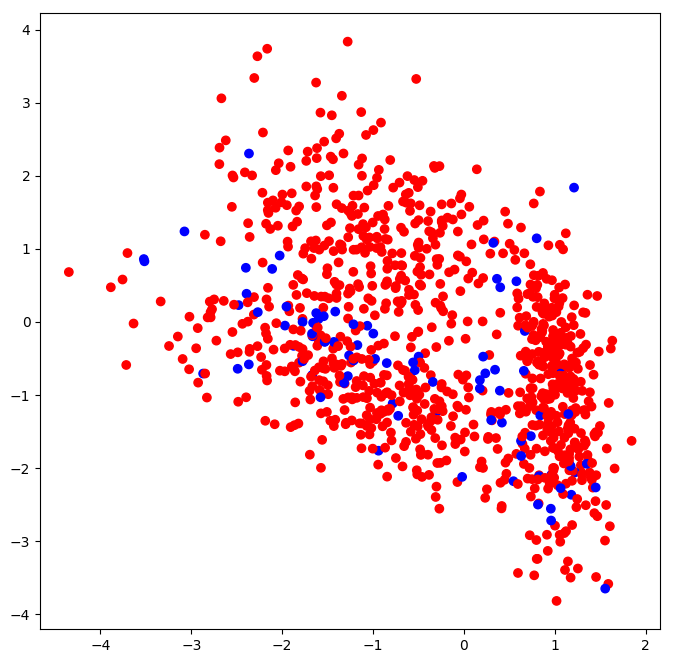

In [274]:
prediction = ann.predict(y)
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], marker='o', c=prediction, cmap='bwr')
plt.show()

As shown above, our ANN classifier had difficulty with the points that were on the boundaries between cluster.  However, we can determine the total accuracy as follows.

In [268]:
sum(prediction)/len(prediction)

0.916

92% - not bad! As mentioned above, classification seemed to be an issue at the borders of the clusters.  We can next visualize the boundaries to get further insight into how the neural network classified the three groups.

In [283]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
mesh = np.c_[xx.ravel(), yy.ravel()]

boundaries = ann.boundary(mesh)
boundaries = boundaries.reshape(xx.shape)

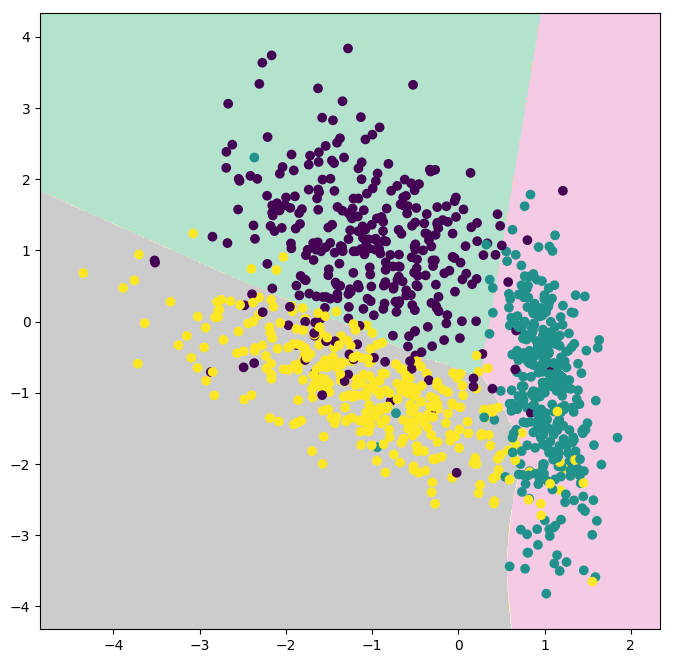

In [289]:
plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, boundaries, cmap='Pastel2')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()
plt.rcdefaults()

As we suspected, the points from each class that overlapped with other clusters were difficult for the ANN to resolve, however we were able to achieve 92% accuracy with this simple three layer model.  The next step in this example would be to determine how well the model generalizes by performing the traditional 70:30 training:test split and learning a new model.  But I will leave that for you!  